In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from bsccm import BSCCM
from encoding_information.datasets.bsccm_utils import *
from encoding_information.information_estimation import *


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-10-14 15:12:43.454422: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 15:12:44.197357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-14 15:12:44.197449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-14 15:12:44.197457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Opening BSCCM
Opened BSCCM


In [2]:
from encoding_information.models import PixelCNN, PoissonNoiseModel

channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
edge_crop = 32
num_images = 5000
num_patches = 5000
photons_per_pixel = 300
num_models_to_train = 8
confidence = .95
patch_size = 50
test_fraction = 0.1


mi_means = []
mi_confidences = []
mi_means_background = []
mi_confidences_background = []
for channel_name in tqdm(channel_names):
    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True, verbose=False)
    patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
    patches = patches * photons_per_pixel / np.mean(images)
    noisy_patches = add_noise(patches)

    train_patches = noisy_patches[:int(len(noisy_patches) * (1 - test_fraction))]
    test_patches = noisy_patches[int(len(noisy_patches) * (1 - test_fraction)):]

    models = []
    for i in range(num_models_to_train):
      pixelcnn = PixelCNN()
      pixelcnn.fit(train_patches, verbose=False)
      models.append(pixelcnn)
    
    noise_model = PoissonNoiseModel()
    estimate, lower, upper = estimate_information(models, noise_model, train_patches, test_patches, confidence_interval=confidence)

    mi_means.append(estimate)
    mi_confidences.append((lower, upper))

    # background
    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, 
                               convert_units_to_photons=True, median_filter=True, verbose=True, empty_slides=True)
    patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
    patches = patches * photons_per_pixel / np.mean(images)
    noisy_patches = add_noise(patches)

    train_patches = noisy_patches[:int(len(noisy_patches) * (1 - test_fraction))]
    test_patches = noisy_patches[int(len(noisy_patches) * (1 - test_fraction)):]

    models = []
    for i in range(num_models_to_train):
      pixelcnn = PixelCNN()
      pixelcnn.fit(train_patches, verbose=False)
      models.append(pixelcnn)

    noise_model = PoissonNoiseModel()
    estimate, lower, upper = estimate_information(models, noise_model, train_patches, test_patches, confidence_interval=confidence)


    mi_means_background.append(estimate)
    mi_confidences_background.append((lower, upper))

    
mi_means = np.array(mi_means)
mi_confidences = np.array(mi_confidences)
mi_means_background = np.array(mi_means_background)
mi_confidences_background = np.array(mi_confidences_background)

  0%|                                                             | 0/3 [00:00<?, ?it/s]2024-10-14 15:13:27.760446: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.

training:  32%|█████████████                           | 65/200 [08:41<18:02,  8.02s/it]

training:  28%|████▉             | 55/200 [07:13<19:03,  7.89s/it]

training:  34%|██████▏           | 69/200 [08:57<17:01,  7.80s/it]

training:  31%|█████▌            | 62/200 [08:05<18:01,  7.83s/it]

training:  26%|████▊             | 53/200 [06:56<19:14,  7.85s/it]

training:  28%|███████████▏                            | 56/200 [07:19<18:49,  7.85s/it]

training:  30%|███████████▊                            | 59/200 [07:51<18:47,  7.99s/it]

training:  32%|████████████▌                           | 63/200 [08:17<18:01,  7.90s/it]

Evaluating NLL: 0it [00:00, ?it/s]
Evaluating NLL: 1it [00:05, 

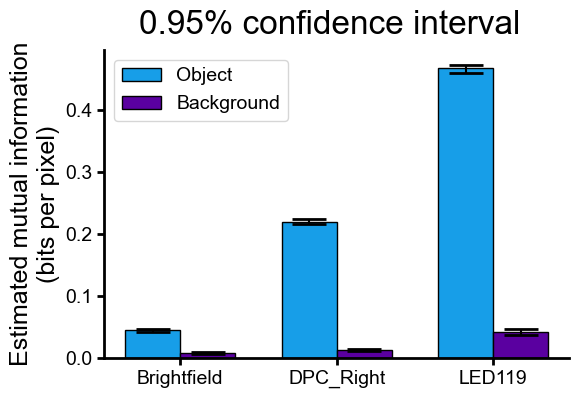

In [3]:

# Parameters for the bar plot
bar_width = 0.35
error_kw = {'capsize': 12, 'capthick': 2}

# Create a paired bar plot of results
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Calculate the errors for the first set of bars
lower_errors = mi_means - mi_confidences[:, 0]
upper_errors = mi_confidences[:, 1] - mi_means

# Calculate the errors for the background set of bars
lower_errors_background = mi_means_background - mi_confidences_background[:, 0]
upper_errors_background = mi_confidences_background[:, 1] - mi_means_background

# Calculate the positions for both sets of bars
positions = np.arange(len(channel_names))
positions_background = positions + bar_width

# Create the bar plots for the first set
ax.bar(
    positions,
    mi_means,
    yerr=np.array([lower_errors, upper_errors]),
    width=bar_width,
    # color='blue',  # Change color as needed
    edgecolor='k',
    linewidth=1,
    error_kw=error_kw,
    label='Object'
)

# Create the bar plots for the background set
ax.bar(
    positions_background,
    mi_means_background,
    yerr=np.array([lower_errors_background, upper_errors_background]),
    width=bar_width,
    # color='green',  # Change color as needed
    edgecolor='k',
    linewidth=1,
    error_kw=error_kw,
    label='Background'
)

# Add labels, title, and legend
ax.set_xticks(positions + bar_width / 2)
ax.set_xticklabels(channel_names)
ax.set_ylabel('Estimated mutual information\n(bits per pixel)')
fig.suptitle(f'{confidence}% confidence interval')
ax.legend()

clear_spines(ax)

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/background_and_forground_mi.pdf', transparent=True)

100%|████████████████████████████████████████████████| 100/100 [00:00<00:00, 412.45it/s]


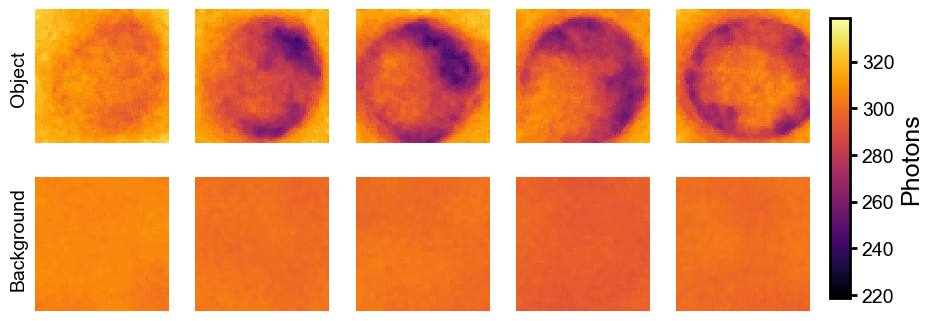

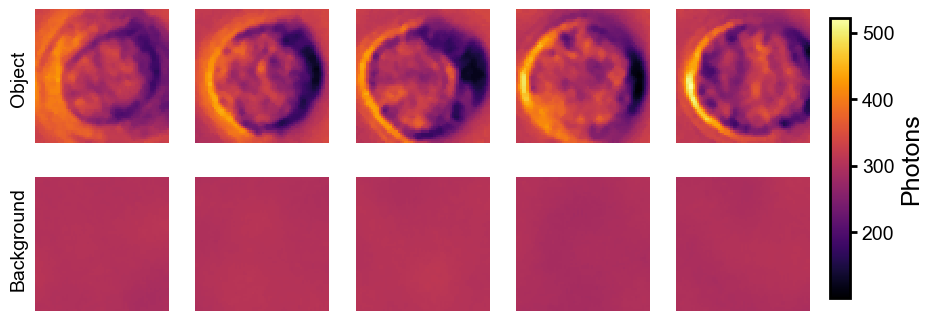

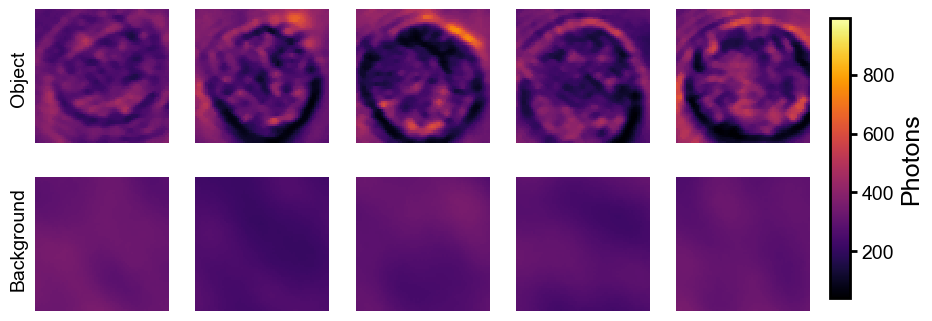

In [4]:
channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
num_images = 100
num_examples = 5


for channel_name in channel_names:
    fig, axs = plt.subplots(2, num_examples, figsize=(10, 4))
    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, 
                               edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True, verbose=False)
    images = images * photons_per_pixel / np.mean(images)

    background_images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, 
                                convert_units_to_photons=True, median_filter=True, verbose=True, empty_slides=True)
    background_images = background_images * photons_per_pixel / np.mean(background_images)
    
    vmin, vmax = np.min(images), np.max(images)
    vmin_background, vmax_background = np.min(background_images), np.max(background_images)

    for i in range(num_examples):
        axs[0, i].imshow(images[i], vmin=vmin, vmax=vmax, cmap='inferno', interpolation='none')
        axs[0, i].axis('off')
        im = axs[1, i].imshow(background_images[i], vmin=vmin, vmax=vmax, cmap='inferno', interpolation='none')
        axs[1, i].axis('off')

    # show colorbar on right side
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # add photons label
    cbar_ax.set_ylabel('Photons')

    # add objects and background labels to left side by adding text to the axes
    fig.text(0.1, 0.7, 'Object', va='center', rotation='vertical')
    fig.text(0.1, 0.3, 'Background', va='center', rotation='vertical')
    fig.savefig(f'/home/hpinkard_waller/figures/mi_estimation/background_and_forground_mi_images{channel_name}.pdf', transparent=True)